In [8]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

df = pd.read_csv('data.csv', index_col = 'ID')     #'P' = Patient    'H' = Healthy
df['class'] = df['class'].astype('category')

print('--- CLASS DISTRIBUTION ---')
print(df['class'].value_counts())

--- CLASS DISTRIBUTION ---
class
P    89
H    85
Name: count, dtype: int64


<h4> OPTIMAL N PCA COMPONENTS </h4>
I will test for the optimal N PCA components for different models by measuring their precision score. Plots will be provided that display the mean scores along with the standard deviations to get insight in PCA performance throughout iterations. 

<h3> DIFFERENT SEEDS </h3>
In different versions of testing I found that the seed could be important in a model's performance. To counter this I implemented multiple iterations to get an average estimate of a model's performance. <br> <br>
I set the random state of the models to 1, so there is no randomness regarding this. The goal of this test is to assess which models perform the best on average, determined by the different seeds and therefore possible different distributions

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

sns.set_style('darkgrid')

X = df.drop('class', axis=1)
y = LabelEncoder().fit_transform(df['class'])

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

max_components = (min(X.shape[0], X.shape[1]) - 1) // 2 #N PCA components to iterate over

classifier_list = [
    LogisticRegression(max_iter=1000, random_state= 1),
    RandomForestClassifier(random_state= 1),
    SVC(random_state= 1),
    XGBClassifier(random_state = 1),
    LGBMClassifier(verbose=-1, random_state =1 )
]


scoring = 'precision'
n_splits = 5 
n_seeds = 5  # N random seeds

all_results = []

for seed in range(n_seeds):
    print(f"Seed: {seed}\n")
    
    results = []
    
    for clf in classifier_list:
        name = clf.__class__.__name__
        print(f"Model: {name}")

        avg_train_scores = np.zeros(max_components)
        avg_test_scores = np.zeros(max_components)
        
        for _ in range(n_splits):
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=True, test_size=0.3, stratify=y, random_state=seed)
            
            train_scores = []
            test_scores = []
            
            for n_components in range(1, max_components + 1):
                pca = PCA(n_components=n_components, random_state=1)
                X_train_pca = pca.fit_transform(X_train)
                X_test_pca = pca.transform(X_test)
                
                clf.set_params(random_state=1)
                clf.fit(X_train_pca, y_train)
                
                y_train_pred = clf.predict(X_train_pca)
                y_test_pred = clf.predict(X_test_pca)
                
                train_score = precision_score(y_train, y_train_pred, average='weighted')
                test_score = precision_score(y_test, y_test_pred, average='weighted')
                
                train_scores.append(train_score)
                test_scores.append(test_score)
            
            avg_train_scores += np.array(train_scores)
            avg_test_scores += np.array(test_scores)
        
        avg_train_scores /= n_splits
        avg_test_scores /= n_splits
        
        best_n_components = np.argmax(avg_test_scores) + 1
        best_score = np.max(avg_test_scores)
        
        results.append({
            'name': name,
            'n_components': best_n_components,
            'test_score': best_score,
            'seed': seed
        })
        

        print(f'{name} best number of components: {best_n_components}')
        print(f'{name} best average test score: {round(best_score, 4)}\n')
    
    all_results.extend(results)

results_df = pd.DataFrame(all_results)

# Calculate average performance across seeds
avg_performance = results_df.groupby('name').agg({
    'n_components': 'mean',
    'test_score': ['mean', 'std']
}).reset_index()
avg_performance.columns = ['name', 'avg_n_components', 'avg_test_score', 'std_test_score']
avg_performance = avg_performance.sort_values('avg_test_score', ascending=False).reset_index(drop=True)

results_df.to_csv('results_dataframe.csv', index=False)
avg_performance.to_csv('avg_performance.csv', index = False)


Seed: 0

Model: LogisticRegression
LogisticRegression best number of components: 31
LogisticRegression best average test score: 0.965

Model: RandomForestClassifier
RandomForestClassifier best number of components: 31
RandomForestClassifier best average test score: 0.8959

Model: SVC
SVC best number of components: 20
SVC best average test score: 0.9346

Model: XGBClassifier
XGBClassifier best number of components: 62
XGBClassifier best average test score: 0.9209

Model: LGBMClassifier
LGBMClassifier best number of components: 22
LGBMClassifier best average test score: 0.8959

Seed: 1

Model: LogisticRegression
LogisticRegression best number of components: 55
LogisticRegression best average test score: 0.8513

Model: RandomForestClassifier
RandomForestClassifier best number of components: 28
RandomForestClassifier best average test score: 0.8819

Model: SVC
SVC best number of components: 8
SVC best average test score: 0.8039

Model: XGBClassifier
XGBClassifier best number of components:

In [13]:
results_df = pd.read_csv('results_dataframe.csv')
avg_performance = pd.read_csv('avg_performance.csv')
avg_performance['avg_n_components'] = avg_performance['avg_n_components'].astype(int)

display(results_df)


,name,n_components,test_score,seed
0,LogisticRegression,31,0.964960,0
1,RandomForestClassifier,31,0.895941,0
2,SVC,20,0.934591,0
3,XGBClassifier,62,0.920876,0
4,LGBMClassifier,22,0.895941,0
5,LogisticRegression,55,0.851267,1
6,RandomForestClassifier,28,0.881896,1
7,SVC,8,0.803934,1
8,XGBClassifier,34,0.834824,1
9,LGBMClassifier,54,0.851267,1


,name,avg_n_components,avg_test_score,std_test_score
0,LogisticRegression,42,0.899223,0.041774
1,RandomForestClassifier,30,0.899065,0.025198
2,LGBMClassifier,27,0.892051,0.034484
3,XGBClassifier,26,0.886080,0.042957
4,SVC,32,0.883178,0.048722


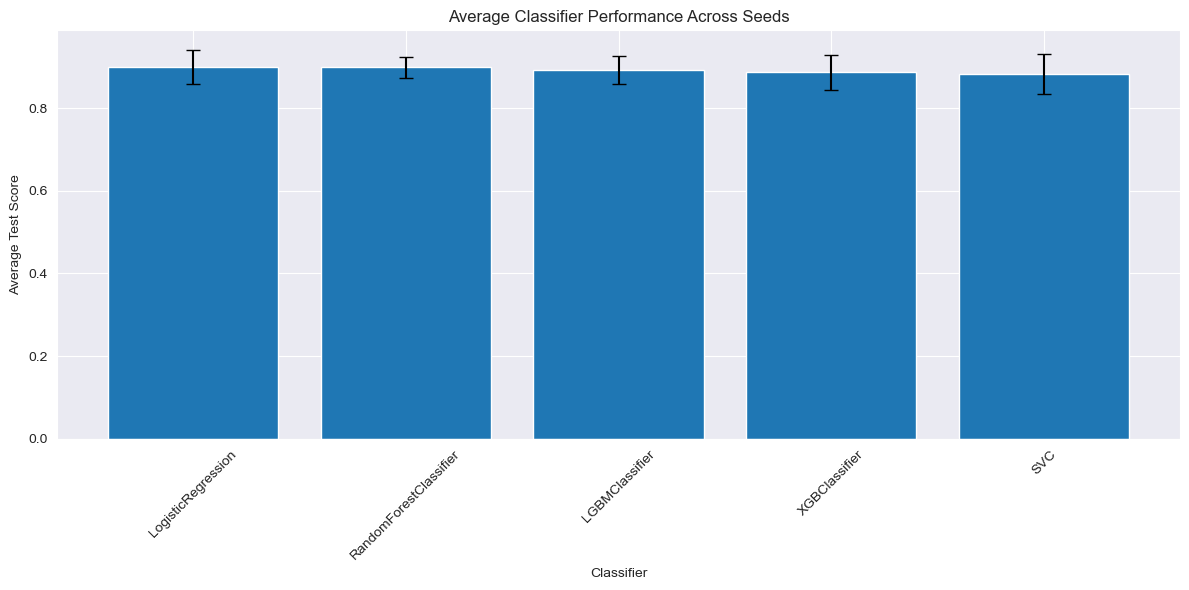

In [12]:
display(avg_performance)

plt.figure(figsize=(12, 6))
plt.bar(avg_performance['name'], avg_performance['avg_test_score'], 
        yerr=avg_performance['std_test_score'], capsize=5)
plt.xlabel('Classifier')
plt.ylabel('Average Test Score')
plt.title('Average Classifier Performance Across Seeds')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h4> RESULTS </h4>
On average, all models perform similar. The best model (in my opinion) for this task is RandomForest, as it has the second-highest score, but the lowest STD. Hopefully in the future, more extensive studies can be done so more patterns regarding Alzheimers can be uncovered. 